# 캐글 노트북 참조해보기
[Feature engineering, xgboost](https://www.kaggle.com/dlarionov/feature-engineering-xgboost)

# Features

In [149]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)

In [150]:
items = pd.read_csv('./data/items.csv')
shops = pd.read_csv('./data/shops.csv')
cats = pd.read_csv('./data/item_categories.csv')
train = pd.read_csv('./data/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('./data/test.csv').set_index('ID')

In [151]:
print(test)

        shop_id  item_id
ID                      
0             5     5037
1             5     5320
2             5     5233
3             5     5232
4             5     5268
...         ...      ...
214195       45    18454
214196       45    16188
214197       45    15757
214198       45    19648
214199       45      969

[214200 rows x 2 columns]


In [152]:
print(shops)

                                          shop_name  shop_id
0                     !Якутск Орджоникидзе, 56 фран        0
1                     !Якутск ТЦ "Центральный" фран        1
2                                  Адыгея ТЦ "Мега"        2
3                    Балашиха ТРК "Октябрь-Киномир"        3
4                          Волжский ТЦ "Волга Молл"        4
5                            Вологда ТРЦ "Мармелад"        5
6                        Воронеж (Плехановская, 13)        6
7                            Воронеж ТРЦ "Максимир"        7
8                      Воронеж ТРЦ Сити-Парк "Град"        8
9                                 Выездная Торговля        9
10                       Жуковский ул. Чкалова 39м?       10
11                       Жуковский ул. Чкалова 39м²       11
12                              Интернет-магазин ЧС       12
13                              Казань ТЦ "Бехетле"       13
14                          Казань ТЦ "ПаркХаус" II       14
15                      

In [4]:
print(cats)

                          item_category_name  item_category_id
0                    PC - Гарнитуры/Наушники                 0
1                           Аксессуары - PS2                 1
2                           Аксессуары - PS3                 2
3                           Аксессуары - PS4                 3
4                           Аксессуары - PSP                 4
5                        Аксессуары - PSVita                 5
6                      Аксессуары - XBOX 360                 6
7                      Аксессуары - XBOX ONE                 7
8                             Билеты (Цифра)                 8
9                            Доставка товара                 9
10                     Игровые консоли - PS2                10
11                     Игровые консоли - PS3                11
12                     Игровые консоли - PS4                12
13                     Игровые консоли - PSP                13
14                  Игровые консоли - PSVita           

## Outliers
price > 100,000 and sales > 1001 인 아이템을 떨궈버리고 했다고 함.
아래에 분포를 그려보니 이해가 됨.

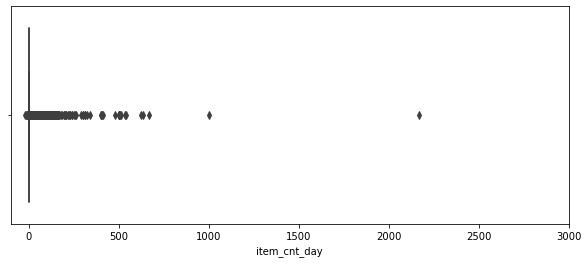

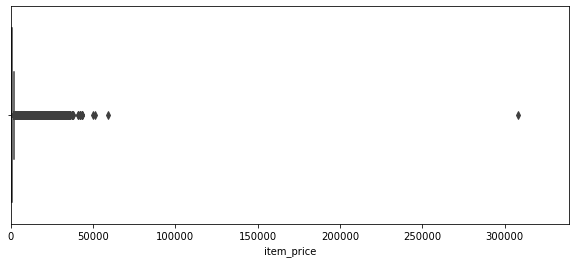

In [153]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [154]:
# 떨궈내기
ITEM_PRICE_LIM = 100000
ITEM_CNT_LIM = 1001
train = train[train.item_price<ITEM_PRICE_LIM]
train = train[train.item_cnt_day<ITEM_CNT_LIM]

가격이 0 미만인 아이템이 있어서 median으로 채웠다고함.

In [155]:
train.loc[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [156]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median
train.loc[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


가게 이름 겹치는 경우 제거했다고 함. 

In [157]:
# Якутск Орджоникидзе, 56 => shop_id 0, 57
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный" => shop_id 1,58
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м² => shop_id 10,11
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## Shops/Cats/Items preprocessing
1. 각 가게 이름이 도시 이름으로 시작한다고 함
2. 각 카테고리 이름 안에 type 과 sub_type이 있다고 함.

In [158]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
# item_category_name 에서 type 꺼내서 따로
cats['type'] = cats['split'].map(lambda x: x[0].strip())
# 따로 꺼낸 type 을 type_code 컬럼에 인코딩한 값 넣기
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

# item_id 사용하니까 name은 드랍
items.drop(['item_name'], axis=1, inplace=True)

### Monthly Sales
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. In the other hand train set contains only pairs which were sold or returned in the past.   

**The main idea is to calculate monthly sales and extend it with zero sales for each unique pair within the month. This way train data will be similar to test data.**

In [159]:
# 363 items are new compared to the train.
print(len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))))
# 5100 items
print(len(list(set(test.item_id))))
# 214200 pairs.
print(len(test))

363
5100
214200


In [160]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
NUM_MONTHS = 34
for i in range(NUM_MONTHS):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
print(matrix)    
# matrix 행으로 쌓은 dataframe 만들기
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
print('=====================================')
print(matrix)
matrix.sort_values(cols,inplace=True)
time.time() - ts

[array([[    0,    59, 22154],
       [    0,    59,  2552],
       [    0,    59,  2554],
       ...,
       [    0,    45,   628],
       [    0,    45,   631],
       [    0,    45,   621]], dtype=int16), array([[    1,    50,  3880],
       [    1,    50,  4128],
       [    1,    50,  4124],
       ...,
       [    1,    28, 12885],
       [    1,    28, 12791],
       [    1,    28, 13433]], dtype=int16), array([[    2,     5, 20175],
       [    2,     5, 20083],
       [    2,     5,    31],
       ...,
       [    2,     4, 12388],
       [    2,     4, 12340],
       [    2,     4, 10649]], dtype=int16), array([[    3,    25,  8092],
       [    3,    25,  7850],
       [    3,    25,  8051],
       ...,
       [    3,    41, 14063],
       [    3,    41, 20690],
       [    3,    41, 19235]], dtype=int16), array([[    4,    59, 22114],
       [    4,    59, 20239],
       [    4,    59, 20238],
       ...,
       [    4,     6,  1924],
       [    4,     6,  1972],
       [ 

11.23777461051941

Aggregate train set by shop/item pairs to calculate target aggreagates, then **clip(0,20) target value.** This way train target will be similar to the test predictions.   

I use floats instead of ints for item_cnt_month to avoid downcasting it after concatination with the test set later.** If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs.**

In [161]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [162]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts


3.0034029483795166

### Test set
To use time tricks append test pairs to the matrix.

In [163]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test.head(5)

,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [164]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.035449981689453125

### Shops/Items/Cats features

In [165]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

2.487400770187378

### Target lags

In [166]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [167]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

18.85355520248413

### Mean encoded features

In [168]:
# 해당 월에, 일반적으로 상품들이 팔린 평균 개수 (즉, 월 단위로 같음.) 과 레그.
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

59.71631383895874

In [21]:
# 해당 월에, 각각의 상품 단위로, 팔린 상품 갯수의 평균 (즉, (월, 상품) 단위) 와 레그.
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

22.203993797302246

In [22]:
# 해당 월에, 각각의 상점 단위로, 팔린 상품 갯수의 평균과 레그. (월, 상점) 단위
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

23.17971110343933

In [23]:
# 해당 월에, 각각의 아이템 카테고리 단위로, 팔린 상품 갯수의 평균과 레그. (월, 아이템 카테고리) 단위
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

7.561230897903442

In [24]:
# 해당 월에, 각각의 상점에서, 아이템 카테고리 단위로, 팔린 상품 갯수의 평균과 레그. (월, 상점, 아이템 카테고리) 단위
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

8.014308452606201

In [25]:
# 해당 월에, 각각의 아이템 타입1 단위로, 팔린 상품 갯수의 평균과 레그. (월, 상점, 타입1) 단위
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

8.086137533187866

In [26]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

8.266505718231201

In [27]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

8.281821727752686

In [28]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

12.43986439704895

In [29]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

8.573117733001709

In [30]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

8.466843128204346

### Trend features
price trend for the last six months

In [31]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')
for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

266.06709909439087

Last month shop revenue trend

In [32]:
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

275.82720947265625

### Special features
Number of days in a month. There are no leap years.

In [33]:
matrix['month'] = matrix['date_block_num'] % 12

In [34]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [35]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta

Months since the last sale for each shop/item pair and for item only.

Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.


item_shop_last_sale   
=> 임시 hash table 생성 (cache)   
=> "<item_id> <shop_id>" 모양으로 키를 만들고   
=> 해당 키가 없고, item이 팔린 양이 0이 아니라면 새로 추가   
=> key 가 있다면, 지난번에 물건이 팔린 날과 이번에 물건이 팔린 날의 차이 값을 집어넣는다.   
=> 그리고 cache 에 이번에 팔린 날의 값을 집어넣는다.   

item_last_sale   
=> 위와 비슷한 방법으로, 이번에 팔린 날이 이미 기록된 팔린 날보다 후라면, 값을 교체해주는 방식

In [36]:
## 근데, 일단 이거 돌리면 커널 죽어서 패스
# ts = time.time()
# cache = {}
# matrix['item_shop_last_sale'] = -1
# matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
# for idx, row in matrix.iterrows():    
#     key = str(row.item_id)+' '+str(row.shop_id)
#     if key not in cache:
#         if row.item_cnt_month!=0:
#             cache[key] = row.date_block_num
#     else:
#         last_date_block_num = cache[key]
#         matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
#         cache[key] = row.date_block_num         
# time.time() - ts

In [37]:
## 근데, 일단 이거 돌리면 커널 죽어서 패스
# ts = time.time()
# cache = {}
# matrix['item_last_sale'] = -1
# matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
# for idx, row in matrix.iterrows():    
#     key = row.item_id
#     if key not in cache:
#         if row.item_cnt_month!=0:
#             cache[key] = row.date_block_num
#     else:
#         last_date_block_num = cache[key]
#         if row.date_block_num>last_date_block_num:
#             matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
#             cache[key] = row.date_block_num         
# time.time() - ts

Months since the first sale for each shop/item pair and for item only.

In [38]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

1.3082993030548096

Because of the using 12 as lag value drop first 12 months.    
Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [39]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

0.500983715057373

Producing lags brings a lot of nulls.

In [40]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

1.1996984481811523

In [41]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta

In [42]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 38 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   city_code                             int8   
 5   item_category_id                      int8   
 6   type_code                             int8   
 7   subtype_code                          int8   
 8   item_cnt_month_lag_1                  float16
 9   item_cnt_month_lag_2                  float16
 10  item_cnt_month_lag_3                  float16
 11  item_cnt_month_lag_6                  float16
 12  item_cnt_month_lag_12                 float16
 13  date_avg_item_cnt_lag_1               float16
 14  date_item_avg_item_cnt_lag_1          float16
 15  date_ite

In [43]:
matrix.to_pickle('data_without_item_last_sale.pkl')
del matrix
# del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# xgboost

In [179]:
def read_data_pickle_and_split():
    # data = pd.read_pickle('data.pkl')
    data = pd.read_pickle('data_without_item_last_sale.pkl')
    # 위에서 만든 feature 들
    data = data[[
        'date_block_num',
        'shop_id',
        'item_id',
        'item_cnt_month',
        'city_code',
        'item_category_id',
        'type_code',
        'subtype_code',
        'item_cnt_month_lag_1',
        'item_cnt_month_lag_2',
        'item_cnt_month_lag_3',
        'item_cnt_month_lag_6',
        'item_cnt_month_lag_12',
        'date_avg_item_cnt_lag_1',
        'date_item_avg_item_cnt_lag_1',
        'date_item_avg_item_cnt_lag_2',
        'date_item_avg_item_cnt_lag_3',
        'date_item_avg_item_cnt_lag_6',
        'date_item_avg_item_cnt_lag_12',
        'date_shop_avg_item_cnt_lag_1',
        'date_shop_avg_item_cnt_lag_2',
        'date_shop_avg_item_cnt_lag_3',
        'date_shop_avg_item_cnt_lag_6',
        'date_shop_avg_item_cnt_lag_12',
        'date_cat_avg_item_cnt_lag_1',
        'date_shop_cat_avg_item_cnt_lag_1',
        #'date_shop_type_avg_item_cnt_lag_1',
        #'date_shop_subtype_avg_item_cnt_lag_1',
        'date_city_avg_item_cnt_lag_1',
        'date_item_city_avg_item_cnt_lag_1',
        #'date_type_avg_item_cnt_lag_1',
        #'date_subtype_avg_item_cnt_lag_1',
        'delta_price_lag',
        'month',
        'days',
    #     두 칼럼 생성 안함 (생성하는 함수 실행 시 커널 죽음)
    #     'item_shop_last_sale',
    #     'item_last_sale',
        'item_shop_first_sale',
        'item_first_sale',
    ]]

    # 13-32 훈련
    # 33 validation
    # 34 test
    X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
    Y_train = data[data.date_block_num < 33]['item_cnt_month']
    X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
    Y_valid = data[data.date_block_num == 33]['item_cnt_month']
    X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
    
    del data
    gc.collect();
    
    return X_train,Y_train,X_valid,Y_valid,X_test

X_train,Y_train,X_valid,Y_valid,X_test = read_data_pickle_and_split()

In [175]:
X_train.tail(5)

,date_block_num,shop_id,item_id,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,month,days,item_shop_first_sale,item_first_sale
10675627,32,59,22162,30,40,11,4,1.0,0.0,0.0,4.0,0.0,0.288086,0.333252,0.627930,0.511719,3.826172,0.000000,0.218506,0.184692,0.172119,0.186768,0.000000,0.242188,0.111633,0.218506,1.0,-0.085815,8,30,14,14
10675628,32,59,22163,30,40,11,4,0.0,0.0,0.0,0.0,0.0,0.288086,0.690430,0.000000,0.000000,0.000000,0.000000,0.218506,0.000000,0.000000,0.000000,0.000000,0.242188,0.111633,0.218506,0.0,-0.008354,8,30,1,1
10675629,32,59,22164,30,37,11,1,0.0,1.0,0.0,1.0,0.0,0.288086,0.476074,0.279053,0.162842,2.000000,0.000000,0.218506,0.184692,0.172119,0.186768,0.000000,0.192017,0.122009,0.218506,0.0,-0.114929,8,30,7,7
10675630,32,59,22166,30,54,12,61,0.0,0.0,0.0,0.0,0.0,0.288086,0.261963,0.186035,0.232544,0.260986,0.260010,0.218506,0.184692,0.172119,0.186768,0.175781,0.143433,0.000000,0.218506,0.0,0.000000,8,30,23,23
10675631,32,59,22167,30,49,12,39,0.0,0.0,0.0,0.0,0.0,0.288086,0.690430,0.790527,0.767578,0.869629,0.779785,0.218506,0.184692,0.172119,0.186768,0.175781,0.161865,0.047607,0.218506,0.0,0.004200,8,30,24,24


In [90]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42
)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[16:08:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.06235	validation_1-rmse:1.04969
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.98653	validation_1-rmse:0.99133
[2]	validation_0-rmse:0.91987	validation_1-rmse:0.94323
[3]	validation_0-rmse:0.88515	validation_1-rmse:0.92212
[4]	validation_0-rmse:0.86425	validation_1-rmse:0.91476
[5]	validation_0-rmse:0.85283	validation_1-rmse:0.91048
[6]	validation_0-rmse:0.84522	validation_1-rmse:0.90912
[7]	validation_0-rmse:0.83916	validation_1-rmse:0.90795
[8]	validation_0-rmse:0.83579	validation_1-rmse:0.90753
[9]	validation_0-rmse:0.83234	validation_1-rmse:0.90804
[10]	

122.35453510284424

In [91]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_without_item_last_sale_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train_without_item_last_sale.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test_without_item_last_sale.pickle', 'wb'))

baseline 제출결과 : 0.92285 (public)

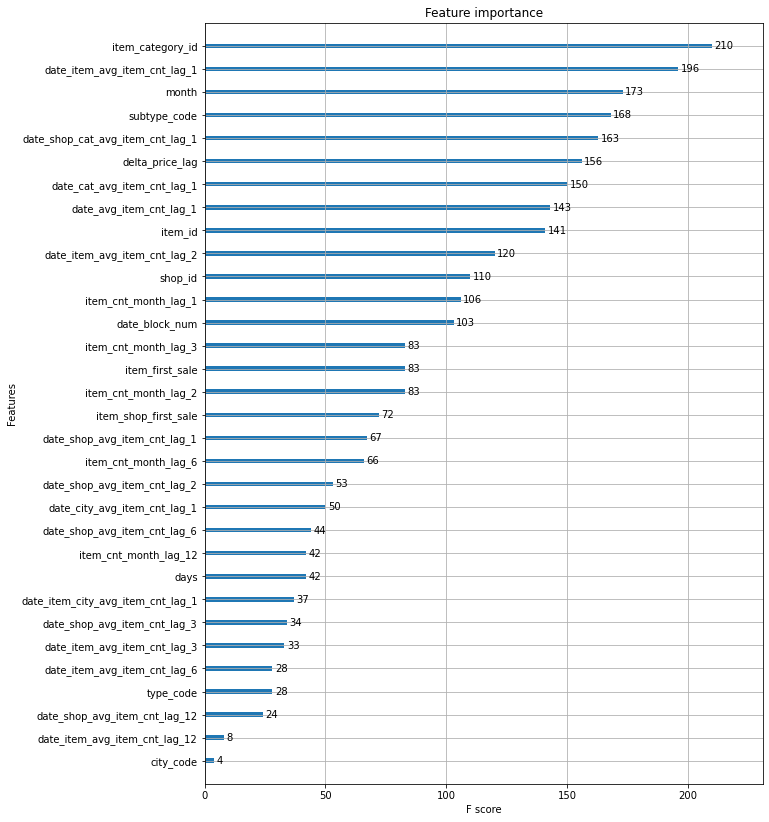

In [92]:
plot_features(model, (10,14))

# 모델 튜닝

In [69]:
models = [GradientBoostingRegressor,XGBRegressor,RandomForestRegressor,LGBMRegressor]
random_state = 2020

In [70]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test,y_pred))

In [78]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=random_state).get_n_splits(X_train.values)
   
    for model in models:
        m = model(random_state=random_state)
        model_name = m.__class__.__name__
        print("Model {} CV score : {:.4f}".format(model_name, np.mean(cross_val_score(m, X_train.values, Y_train)), 
                                                  kf=kfold))

In [ ]:
# ts = time.time()
# get_cv_score(models)
# time.time()-ts

In [80]:
# def get_scores(models):
#   df = {}
#   for model in models:
    
#     m = model(random_state=random_state)
#     # 모델 이름 획득
#     model_name = m.__class__.__name__
    
#     # 모델 학습
#     m.fit(X_train, Y_train)
    
#     # 예측
#     y_pred = m.predict(X_test)

#     # 예측 결과의 rmse값 저장
#     df[model_name] = rmse(Y_test, y_pred)
    
#     # data frame에 저장
#     score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
#   return score_df

# get_scores(models)

In [81]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=10):
  # 1. GridSearchCV 모델로 `model`을 초기화합니다.
  grid_model = GridSearchCV(model, param_grid=param_grid, \
                          scoring='neg_mean_squared_error', \
                          cv=5,verbose=verbose, n_jobs=n_jobs)
  # 2. 모델을 fitting 합니다.
  grid_model.fit(train, y)
  
  # 3. params, score에 각 조합에 대한 결과를 저장합니다. 
  params = grid_model.cv_results_['params']
  score = grid_model.cv_results_['mean_test_score']
  
  # 4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
  results = pd.DataFrame(params)
  results['score'] = score
  
  results['RMSLE'] = np.sqrt(-1 * results['score'])
  results.sort_values('RMSLE',inplace=True)

  return results

In [82]:
random_state = 2020
RMSLE_list = []

def get_searched_model(model,params):
    m = model(random_state=random_state)
    model_name = m.__class__.__name__
        
    results = my_GridSearch(m, X_train, Y_train, params, verbose=2, n_jobs=10)
   
    learning_rate = 0.0 
    
    if model_name != 'RandomForestRegressor':
        learning_rate = results.loc[results.index[0],:]['learning_rate']
        
    max_depth = results.loc[results.index[0],:]['max_depth']
    n_estimators = results.loc[results.index[0],:]['n_estimators']
    RMSLE = results.loc[results.index[0],:]['RMSLE']
    
    print(model_name,learning_rate, max_depth,n_estimators,RMSLE)
    
    RMSLE_list.append((model_name,RMSLE))

## 그리드 서치 시도
데이터가 너무 커서 안돌아감
=> 포기하고 그냥 임의로 해보려고 함.

In [ ]:
# # models = [GradientBoostingRegressor,XGBRegressor,RandomForestRegressor,LGBMRegressor]
# learning_rates = [0.0001,0.001,0.01,0.1]
# max_depth = [8,10]
# n_estimators = [500,1000,1500]

# GBR_param_grid = {
#     'n_estimators': n_estimators,
#     'max_depth': max_depth,
#     'learning_rate' : learning_rates
# }
# get_searched_model(models[0],GBR_param_grid)

In [ ]:
# XGB_param_grid = {
#     'max_depth' : [8],
#     'n_estimators':[1000],
#     'min_child_weight':[300], 
#     'colsample_bytree':[0.8], 
#     'subsample':[0.8], 
#     'eta':[0.3],
#     'seed':[42],
#     'learning_rates':learning_rates
# }
# get_searched_model(models[1],XGB_param_grid)

In [ ]:
# RFR_param_grid = {
#     'n_estimators': n_estimators,
#     'max_depth': max_depth,
# }
# get_searched_model(models[2],RFR_param_grid)

In [ ]:
# LGMB_param_grid = {
#     'max_depth' : [8],
#     'n_estimators':[1000],
#     'min_child_weight':[300], 
#     'colsample_bytree':[0.8], 
#     'subsample':[0.8], 
#     'eta':[0.3],    
#     'seed':[42],
#     'learning_rates':learning_rates
# }
# get_searched_model(models[3],LGMB_param_grid)

가장 낮게 나오는 모델로 다시 해보자.
근데 너무 안돌아간다... 임의로 해보자

In [198]:
def predict_and_make_submission(model,messages):
    Y_pred = model.predict(X_valid).clip(0, 20)
    Y_test = model.predict(X_test).clip(0, 20)
    model_name = model.__class__.__name__

    submission = pd.DataFrame({
        "ID": test.index, 
        "item_cnt_month": Y_test
    })
    submission.to_csv('{}_{}_without_item_last_sale_submission.csv'.format(model_name,messages), index=False)

    # save predictions for an ensemble
    pickle.dump(Y_pred, open('{}_{}_train_without_item_last_sale.pickle'.format(model_name,messages), 'wb'))
    pickle.dump(Y_test, open('{}_{}_test_without_item_last_sale.pickle'.format(model_name,messages), 'wb'))
    
    #return Y_test

In [94]:
ts = time.time()

# XGB로 가정
best_model = models[1]

# learning_rate 0.01 조정해봄
model = best_model(
   # params
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta = 0.3,    
    seed = 42,
    learning_rate = 0.01
)

model.fit(
        X_train, 
        Y_train, 
        eval_metric="rmse", 
        eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
        verbose=True, 
        early_stopping_rounds = 10
    )

time.time() - ts

[16:25:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.20243	validation_1-rmse:1.15728
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.19789	validation_1-rmse:1.15336
[2]	validation_0-rmse:1.19291	validation_1-rmse:1.14878
[3]	validation_0-rmse:1.18573	validation_1-rmse:1.14476
[4]	validation_0-rmse:1.18050	validation_1-rmse:1.14037
[5]	validation_0-rmse:1.17509	validation_1-rmse:1.13618
[6]	validation_0-rmse:1.17043	validation_1-rmse:1.13244
[7]	validation_0-rmse:1.16553	validation_1-rmse:1.12849
[8]	validation_0-rmse:1.16181	validation_1-rmse:1.12517
[9]	validation_0-rmse:1.15707	validation_1-rmse:1.12107
[10]	

[136]	validation_0-rmse:0.88240	validation_1-rmse:0.92692
[137]	validation_0-rmse:0.88172	validation_1-rmse:0.92655
[138]	validation_0-rmse:0.88104	validation_1-rmse:0.92623
[139]	validation_0-rmse:0.88037	validation_1-rmse:0.92587
[140]	validation_0-rmse:0.87971	validation_1-rmse:0.92551
[141]	validation_0-rmse:0.87899	validation_1-rmse:0.92511
[142]	validation_0-rmse:0.87834	validation_1-rmse:0.92478
[143]	validation_0-rmse:0.87773	validation_1-rmse:0.92452
[144]	validation_0-rmse:0.87716	validation_1-rmse:0.92423
[145]	validation_0-rmse:0.87654	validation_1-rmse:0.92395
[146]	validation_0-rmse:0.87598	validation_1-rmse:0.92370
[147]	validation_0-rmse:0.87535	validation_1-rmse:0.92334
[148]	validation_0-rmse:0.87476	validation_1-rmse:0.92303
[149]	validation_0-rmse:0.87422	validation_1-rmse:0.92275
[150]	validation_0-rmse:0.87360	validation_1-rmse:0.92241
[151]	validation_0-rmse:0.87288	validation_1-rmse:0.92207
[152]	validation_0-rmse:0.87228	validation_1-rmse:0.92175
[153]	validati

[278]	validation_0-rmse:0.83439	validation_1-rmse:0.90751
[279]	validation_0-rmse:0.83421	validation_1-rmse:0.90749
[280]	validation_0-rmse:0.83409	validation_1-rmse:0.90750
[281]	validation_0-rmse:0.83391	validation_1-rmse:0.90744
[282]	validation_0-rmse:0.83377	validation_1-rmse:0.90747
[283]	validation_0-rmse:0.83362	validation_1-rmse:0.90743
[284]	validation_0-rmse:0.83344	validation_1-rmse:0.90740
[285]	validation_0-rmse:0.83330	validation_1-rmse:0.90741
[286]	validation_0-rmse:0.83312	validation_1-rmse:0.90736
[287]	validation_0-rmse:0.83298	validation_1-rmse:0.90734
[288]	validation_0-rmse:0.83281	validation_1-rmse:0.90729
[289]	validation_0-rmse:0.83267	validation_1-rmse:0.90722
[290]	validation_0-rmse:0.83251	validation_1-rmse:0.90720
[291]	validation_0-rmse:0.83237	validation_1-rmse:0.90720
[292]	validation_0-rmse:0.83220	validation_1-rmse:0.90716
[293]	validation_0-rmse:0.83204	validation_1-rmse:0.90711
[294]	validation_0-rmse:0.83187	validation_1-rmse:0.90702
[295]	validati

1753.9532492160797

별 차이 없음

In [104]:
ts = time.time()

# XGB로 가정
best_model = models[1]

# n_estimators 2000 으로 조정해봄
model = best_model(
   # params
    max_depth=8,
    n_estimators=2000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta = 0.3,    
    seed = 42,
    learning_rate = 0.1
)

model.fit(
        X_train, 
        Y_train, 
        eval_metric="rmse", 
        eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
        verbose=True, 
        early_stopping_rounds = 10
    )

time.time() - ts

[16:56:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.15627	validation_1-rmse:1.12055
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.11541	validation_1-rmse:1.08817
[2]	validation_0-rmse:1.07235	validation_1-rmse:1.05457
[3]	validation_0-rmse:1.03808	validation_1-rmse:1.02920
[4]	validation_0-rmse:1.00662	validation_1-rmse:1.00658
[5]	validation_0-rmse:0.98089	validation_1-rmse:0.98840
[6]	validation_0-rmse:0.95984	validation_1-rmse:0.97451
[7]	validation_0-rmse:0.94181	validation_1-rmse:0.96223
[8]	validation_0-rmse:0.92905	validation_1-rmse:0.95273
[9]	validation_0-rmse:0.91445	validation_1-rmse:0.94351
[10]	

262.0400640964508

별 차이 없음
그냥 원래 하던대로 다시. 단, 이번엔 early_stopping을 높게

In [199]:
ts = time.time()

# XGB로 가정
best_model = models[1]

model = best_model(
   # params
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta = 0.3,    
    seed = 42,
    learning_rate = 0.1
)

model.fit(
        X_train, 
        Y_train, 
        eval_metric="rmse", 
        eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
        verbose=True, 
        early_stopping_rounds = 30
    )

time.time() - ts

[17:50:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.15627	validation_1-rmse:1.12055
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:1.11541	validation_1-rmse:1.08817
[2]	validation_0-rmse:1.07235	validation_1-rmse:1.05457
[3]	validation_0-rmse:1.03808	validation_1-rmse:1.02920
[4]	validation_0-rmse:1.00662	validation_1-rmse:1.00658
[5]	validation_0-rmse:0.98089	validation_1-rmse:0.98840
[6]	validation_0-rmse:0.95984	validation_1-rmse:0.97451
[7]	validation_0-rmse:0.94181	validation_1-rmse:0.96223
[8]	validation_0-rmse:0.92905	validation_1-rmse:0.95273
[9]	validation_0-rmse:0.91445	validation_1-rmse:0.94351
[10]	

359.8530728816986

In [200]:
predict_and_make_submission(model,'early_stopping30')

In [201]:
ts = time.time()

# LGMB으로 가정
best_model = models[3]

# LGBM 해보자
model = best_model(
   # params
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8,
    eta = 0.3,
    seed = 42,
    learning_rate = 0.1
)

model.fit(
        X_train, 
        Y_train, 
        eval_metric="rmse", 
        eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
        verbose=True, 
        early_stopping_rounds = 30
    )

time.time() - ts

[1]	training's rmse: 1.14254	training's l2: 1.3054	valid_1's rmse: 1.10191	valid_1's l2: 1.21421
Training until validation scores don't improve for 30 rounds
[2]	training's rmse: 1.10262	training's l2: 1.21578	valid_1's rmse: 1.07225	valid_1's l2: 1.14972
[3]	training's rmse: 1.06582	training's l2: 1.13598	valid_1's rmse: 1.04559	valid_1's l2: 1.09326
[4]	training's rmse: 1.03463	training's l2: 1.07046	valid_1's rmse: 1.02339	valid_1's l2: 1.04732
[5]	training's rmse: 1.0087	training's l2: 1.01748	valid_1's rmse: 1.00503	valid_1's l2: 1.01008
[6]	training's rmse: 0.986444	training's l2: 0.973071	valid_1's rmse: 0.990123	valid_1's l2: 0.980344
[7]	training's rmse: 0.967406	training's l2: 0.935874	valid_1's rmse: 0.977803	valid_1's l2: 0.956098
[8]	training's rmse: 0.951754	training's l2: 0.905835	valid_1's rmse: 0.968002	valid_1's l2: 0.937027
[9]	training's rmse: 0.938676	training's l2: 0.881113	valid_1's rmse: 0.958867	valid_1's l2: 0.919426
[10]	training's rmse: 0.927097	training's l

[81]	training's rmse: 0.823063	training's l2: 0.677432	valid_1's rmse: 0.915442	valid_1's l2: 0.838033
[82]	training's rmse: 0.822834	training's l2: 0.677057	valid_1's rmse: 0.9154	valid_1's l2: 0.837957
[83]	training's rmse: 0.822122	training's l2: 0.675885	valid_1's rmse: 0.914868	valid_1's l2: 0.836983
[84]	training's rmse: 0.821813	training's l2: 0.675377	valid_1's rmse: 0.915104	valid_1's l2: 0.837416
[85]	training's rmse: 0.821579	training's l2: 0.674992	valid_1's rmse: 0.914932	valid_1's l2: 0.837101
[86]	training's rmse: 0.821391	training's l2: 0.674684	valid_1's rmse: 0.914915	valid_1's l2: 0.837069
[87]	training's rmse: 0.820614	training's l2: 0.673407	valid_1's rmse: 0.914843	valid_1's l2: 0.836938
[88]	training's rmse: 0.820328	training's l2: 0.672938	valid_1's rmse: 0.914652	valid_1's l2: 0.836588
[89]	training's rmse: 0.820086	training's l2: 0.672542	valid_1's rmse: 0.915567	valid_1's l2: 0.838262
[90]	training's rmse: 0.81983	training's l2: 0.672122	valid_1's rmse: 0.915

[162]	training's rmse: 0.803164	training's l2: 0.645073	valid_1's rmse: 0.914173	valid_1's l2: 0.835712
[163]	training's rmse: 0.803076	training's l2: 0.64493	valid_1's rmse: 0.914143	valid_1's l2: 0.835657
[164]	training's rmse: 0.802965	training's l2: 0.644752	valid_1's rmse: 0.914186	valid_1's l2: 0.835736
[165]	training's rmse: 0.80283	training's l2: 0.644536	valid_1's rmse: 0.914057	valid_1's l2: 0.835501
[166]	training's rmse: 0.802673	training's l2: 0.644284	valid_1's rmse: 0.914096	valid_1's l2: 0.835572
[167]	training's rmse: 0.802565	training's l2: 0.644111	valid_1's rmse: 0.914095	valid_1's l2: 0.83557
[168]	training's rmse: 0.802429	training's l2: 0.643892	valid_1's rmse: 0.914049	valid_1's l2: 0.835485
[169]	training's rmse: 0.802258	training's l2: 0.643618	valid_1's rmse: 0.913752	valid_1's l2: 0.834944
[170]	training's rmse: 0.801961	training's l2: 0.643142	valid_1's rmse: 0.913561	valid_1's l2: 0.834594
[171]	training's rmse: 0.801839	training's l2: 0.642946	valid_1's r

[243]	training's rmse: 0.789781	training's l2: 0.623755	valid_1's rmse: 0.914513	valid_1's l2: 0.836334
[244]	training's rmse: 0.789709	training's l2: 0.62364	valid_1's rmse: 0.914514	valid_1's l2: 0.836336
Early stopping, best iteration is:
[214]	training's rmse: 0.794812	training's l2: 0.631726	valid_1's rmse: 0.91229	valid_1's l2: 0.832273


61.2362904548645

In [202]:
predict_and_make_submission(model,'early_stopping30')

early stopping 10 일때,   
제출 결과 : 0.92075 (public)

early stopping 30 일때는 제출 안하고 ensemble 해서 제출

# 앙상블시도

## Average

In [180]:
def AveragingBlending(preds):     
    
    predictions = np.column_stack([
       pred for pred in preds
    ])
    
    return np.mean(predictions, axis=1)

In [205]:
def submission_for_ensemble(names,messages,Y_test):
    submission = pd.DataFrame({
        "ID": test.index, 
        "item_cnt_month": Y_test
    })
    submission.to_csv('ensemble_{0}_{1}_without_item_last_sale_submission.csv'.format(names,messages), index=False)

In [207]:
messages = 'early_stopping10'
xgb_pred = pd.read_pickle('xgb_train_without_item_last_sale.pickle')
xgb_test = pd.read_pickle('xgb_test_without_item_last_sale.pickle')
lgbm_pred = pd.read_pickle('LGBMRegressor_train_without_item_last_sale.pickle')
lgbm_test = pd.read_pickle('LGBMRegressor_test_without_item_last_sale.pickle')

preds = [xgb_pred,lgbm_pred]
tests = [xgb_test,lgbm_test]
Y_pred = AveragingBlending(preds).clip(0, 20)
Y_test = AveragingBlending(tests).clip(0, 20)
print(Y_pred)
print(Y_test)

submission_for_ensemble('xgb,lgbm',messages,Y_test)

[0.02559268 0.09056555 0.18106915 ... 0.20234955 0.02955666 0.08232767]
[0.52475634 0.44900026 1.45687039 ... 0.05064126 0.02954725 0.05210531]


### xgb,lgbm ensemble 제출결과
0.91822 (public)

## Average with early stopping 30 적용한 모델들

In [206]:
messages = 'early_stopping30'
xgb_pred = pd.read_pickle('XGBRegressor_{}_train_without_item_last_sale.pickle'.format(messages))
xgb_test = pd.read_pickle('XGBRegressor_{}_test_without_item_last_sale.pickle'.format(messages))
lgbm_pred = pd.read_pickle('LGBMRegressor_{}_train_without_item_last_sale.pickle'.format(messages))
lgbm_test = pd.read_pickle('LGBMRegressor_{}_test_without_item_last_sale.pickle'.format(messages))

preds = [xgb_pred,lgbm_pred]
tests = [xgb_test,lgbm_test]
Y_pred = AveragingBlending(preds).clip(0, 20)
Y_test = AveragingBlending(tests).clip(0, 20)
print(Y_pred)
print(Y_test)

submission_for_ensemble('xgb,lgbm',messages,Y_test)

[0.02114534 0.10255508 0.20431208 ... 0.18224813 0.01800352 0.09184029]
[0.61422242 0.40440915 1.6638079  ... 0.04989801 0.02515631 0.04631558]


### xgb,lgbm earlystopping30 ensemble 제출 결과
0.91003 (public)